<a href="https://colab.research.google.com/github/pradeepprasad/Machine_Learning_Workspace/blob/master/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

starting game  0
starting game  5000
starting game  10000
starting game  15000
starting game  20000
starting game  25000
starting game  30000
starting game  35000
starting game  40000
starting game  45000


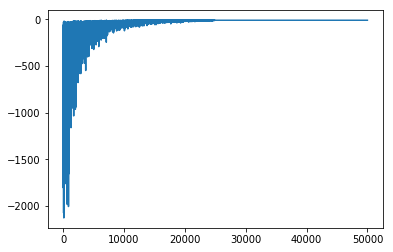

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld(object):
    def __init__(self, m, n, magicSquares):
        self.grid = np.zeros((m,n))
        self.m = m
        self.n = n
        self.stateSpace = [i for i in range(self.m*self.n)]
        self.stateSpace.remove(80)
        self.stateSpacePlus = [i for i in range(self.m*self.n)]
        self.actionSpace = {'U': -self.m, 'D': self.m,
                            'L': -1, 'R': 1}
        self.possibleActions = ['U', 'D', 'L', 'R']
        # dict with magic squares and resulting squares
        self.addMagicSquares(magicSquares)
        self.agentPosition = 0

    def isTerminalState(self, state):
        return state in self.stateSpacePlus and state not in self.stateSpace

    def addMagicSquares(self, magicSquares):
        self.magicSquares = magicSquares
        i = 2
        for square in self.magicSquares:
            x = square // self.m
            y = square % self.n
            self.grid[x][y] = i
            i += 1
            x = magicSquares[square] // self.m
            y = magicSquares[square] % self.n
            self.grid[x][y] = i
            i += 1

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.m
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 0
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1

    def offGridMove(self, newState, oldState):
        # if we move into a row not in the grid
        if newState not in self.stateSpacePlus:
            return True
        # if we're trying to wrap around to next row
        elif oldState % self.m == 0 and newState  % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and newState % self.m == 0:
            return True
        else:
            return False

    def step(self, action):
        agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]
        if resultingState in self.magicSquares.keys():
            resultingState = magicSquares[resultingState]

        reward = -1 if not self.isTerminalState(resultingState) else 0
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return resultingState, reward, \
                   self.isTerminalState(resultingState), None
        else:
            return self.agentPosition, reward, \
                   self.isTerminalState(self.agentPosition), None

    def reset(self):
        self.agentPosition = 0
        self.grid = np.zeros((self.m,self.n))
        self.addMagicSquares(self.magicSquares)
        return self.agentPosition

    def render(self):
        print('------------------------------------------')
        for row in self.grid:
            for col in row:
                if col == 0:
                    print('-', end='\t')
                elif col == 1:
                    print('X', end='\t')
                elif col == 2:
                    print('Ain', end='\t')
                elif col == 3:
                    print('Aout', end='\t')
                elif col == 4:
                    print('Bin', end='\t')
                elif col == 5:
                    print('Bout', end='\t')
            print('\n')
        print('------------------------------------------')

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

def maxAction(Q, state, actions):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return actions[action]

if __name__ == '__main__':
    # map magic squares to their connecting square
    magicSquares = {18: 54, 63: 14}
    env = GridWorld(9, 9, magicSquares)
    # model hyperparameters
    ALPHA = 0.1
    GAMMA = 1.0
    EPS = 1.0

    Q = {}
    for state in env.stateSpacePlus:
        for action in env.possibleActions:
            Q[state, action] = 0

    numGames = 50000
    totalRewards = np.zeros(numGames)
    for i in range(numGames):
        if i % 5000 == 0:
            print('starting game ', i)
        done = False
        epRewards = 0
        observation = env.reset()
        while not done:
            rand = np.random.random()
            action = maxAction(Q,observation, env.possibleActions) if rand < (1-EPS) \
                                                    else env.actionSpaceSample()
            observation_, reward, done, info = env.step(action)
            epRewards += reward

            action_ = maxAction(Q, observation_, env.possibleActions)
            Q[observation,action] = Q[observation,action] + ALPHA*(reward + \
                        GAMMA*Q[observation_,action_] - Q[observation,action])
            observation = observation_
        if EPS - 2 / numGames > 0:
            EPS -= 2 / numGames
        else:
            EPS = 0
        totalRewards[i] = epRewards

    plt.plot(totalRewards)
    plt.show()